# load papers into memory and store a list of JSON objects

In [1]:
import os
import json
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Download required NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

def load_papers(directory_path, limit=None):
    """
    Load papers from JSON files in a directory structure
    
    Args:
        directory_path: Path to the directory containing JSON files
        limit: Maximum number of papers to load (for testing)
        
    Returns:
        List of paper dictionaries
    """
    papers = []
    logging.info(f"Loading papers from {directory_path}")
    
    counter = 0
    for root, _, files in os.walk(directory_path):
        for file in files:
            if limit and counter >= limit:
                break
                
            if file.endswith('.json'):
                counter += 1
                print(f"\rProcessing: {counter}", end='', flush=True)
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        paper_data = json.load(f)
                    
                    # Add file path information for reference
                    paper_data['file_path'] = file_path
                    papers.append(paper_data)
                                            
                except Exception as e:  
                    logging.error(f"Error loading {file_path}: {e}")
        
        if limit and counter >= limit:
            break
            
    logging.info(f"Finished loading {counter} papers")
    return papers

# Load a sample of papers for demonstration
papers = load_papers('irCOREdata', limit=None)

2025-03-25 13:08:23,226 - INFO - Loading papers from irCOREdata


Processing: 21840

2025-03-25 13:08:35,270 - INFO - Finished loading 21840 papers


# data exploration 

In [2]:
def analyze_missing_fields(papers):
    """
    Analyzes how fields are missing in the papers dataset.
    Distinguishes between missing keys, None values, empty strings, and empty lists.
    """
    total_papers = len(papers)
    
    # Initialize counters for different types of missing data
    field_stats = {
        'title': {'missing_key': 0, 'is_none': 0, 'empty_string': 0, 'empty_list': 0},
        'abstract': {'missing_key': 0, 'is_none': 0, 'empty_string': 0, 'empty_list': 0},
        'fullText': {'missing_key': 0, 'is_none': 0, 'empty_string': 0, 'empty_list': 0},
        'topics': {'missing_key': 0, 'is_none': 0, 'empty_string': 0, 'empty_list': 0}
    }
    
    # Check each paper and count different ways fields can be missing
    for paper in papers:
        for field in field_stats.keys():
            # Check if the key is missing
            if field not in paper:
                field_stats[field]['missing_key'] += 1
            # Key exists but value is None
            elif paper[field] is None:
                field_stats[field]['is_none'] += 1
            # Key exists but value is empty string
            elif isinstance(paper[field], str) and paper[field].strip() == '':
                field_stats[field]['empty_string'] += 1
            # Key exists but value is empty list
            elif isinstance(paper[field], list) and len(paper[field]) == 0:
                field_stats[field]['empty_list'] += 1
    
    # Print the results
    print(f"Analysis of missing fields across {total_papers} papers:\n")
    
    for field in field_stats:
        stats = field_stats[field]
        total_missing = stats['missing_key'] + stats['is_none'] + stats['empty_string'] + stats['empty_list']
        
        print(f"=== {field.upper()} FIELD ===")
        print(f"Total effectively missing: {total_missing} ({total_missing/total_papers:.1%})")
        print(f"  - Key not in JSON: {stats['missing_key']} ({stats['missing_key']/total_papers:.1%})")
        print(f"  - Value is None: {stats['is_none']} ({stats['is_none']/total_papers:.1%})")
        print(f"  - Empty string: {stats['empty_string']} ({stats['empty_string']/total_papers:.1%})")
        print(f"  - Empty list: {stats['empty_list']} ({stats['empty_list']/total_papers:.1%})\n")
    
    # Also calculate how many papers are missing specific combinations of fields
    missing_abstract_and_fulltext = 0
    missing_title = 0
    missing_all_three = 0
    
    for paper in papers:
        # Check title
        has_title = ('title' in paper and paper['title'] is not None and 
                    isinstance(paper['title'], str) and paper['title'].strip() != '')
        
        # Check abstract
        has_abstract = ('abstract' in paper and paper['abstract'] is not None and 
                       isinstance(paper['abstract'], str) and paper['abstract'].strip() != '')
        
        # Check fullText
        has_fulltext = ('fullText' in paper and paper['fullText'] is not None and 
                       isinstance(paper['fullText'], str) and paper['fullText'].strip() != '')
        
        # Count papers missing combinations
        if not has_title:
            missing_title += 1
            
        if not has_abstract and not has_fulltext:
            missing_abstract_and_fulltext += 1
            
        if not has_title and not has_abstract and not has_fulltext:
            missing_all_three += 1
    
    print(f"=== FIELD COMBINATIONS ===")
    print(f"Papers missing title: {missing_title} ({missing_title/total_papers:.1%})")
    print(f"Papers missing both abstract AND fullText: {missing_abstract_and_fulltext} ({missing_abstract_and_fulltext/total_papers:.1%})")
    print(f"Papers missing all three main fields: {missing_all_three} ({missing_all_three/total_papers:.1%})")
    
    return field_stats

# Run the analysis
field_stats = analyze_missing_fields(papers)

Analysis of missing fields across 21840 papers:

=== TITLE FIELD ===
Total effectively missing: 0 (0.0%)
  - Key not in JSON: 0 (0.0%)
  - Value is None: 0 (0.0%)
  - Empty string: 0 (0.0%)
  - Empty list: 0 (0.0%)

=== ABSTRACT FIELD ===
Total effectively missing: 5947 (27.2%)
  - Key not in JSON: 0 (0.0%)
  - Value is None: 5947 (27.2%)
  - Empty string: 0 (0.0%)
  - Empty list: 0 (0.0%)

=== FULLTEXT FIELD ===
Total effectively missing: 13243 (60.6%)
  - Key not in JSON: 0 (0.0%)
  - Value is None: 11125 (50.9%)
  - Empty string: 2118 (9.7%)
  - Empty list: 0 (0.0%)

=== TOPICS FIELD ===
Total effectively missing: 5422 (24.8%)
  - Key not in JSON: 0 (0.0%)
  - Value is None: 0 (0.0%)
  - Empty string: 0 (0.0%)
  - Empty list: 5422 (24.8%)

=== FIELD COMBINATIONS ===
Papers missing title: 0 (0.0%)
Papers missing both abstract AND fullText: 4890 (22.4%)
Papers missing all three main fields: 0 (0.0%)


# extarct fields

In [3]:
def extract_fields(papers):
    """
    Extract title, abstract and body text from papers
    
    Args:
        papers: List of paper dictionaries
        
    Returns:
        Dictionary of extracted fields and paper IDs
    """
    titles = []
    abstracts = []
    bodies = []
    paper_ids = []
    topics = []
    counter = 0
    for paper in papers:
        counter += 1
        print(f"\rProcessing: {counter}", end='', flush=True)
        # Extract ID
        paper_id = paper.get('coreId')
        paper_ids.append(paper_id)  
        
        # Extract title - handle missing cases
        title = paper.get('title')
        titles.append(title if isinstance(title, str) and title.strip() != '' else '')
        
        # Extract abstract - handle None values
        abstract = paper.get('abstract')
        abstracts.append(abstract if isinstance(abstract, str) and abstract.strip() != '' else '')
        
        # Extract fullText - handle None values and empty strings
        fulltext = paper.get('fullText')
        bodies.append(fulltext if isinstance(fulltext, str) and fulltext.strip() != '' else '')
        
        # Extract topics - handle empty lists
        topic_data = paper.get('topics')
        if isinstance(topic_data, list) and len(topic_data) > 0:
            topics.append(topic_data)
        else:
            topics.append('')
    
    return {
        'paper_ids': paper_ids,
        'titles': titles,
        'abstracts': abstracts,
        'bodies': bodies,
        'topics': topics
    }

# Extract fields from loaded papers
extracted_fields_dict = extract_fields(papers)


Processing: 21840

# visualize the fields and their analysis

In [4]:
def create_papers_dataframe(extracted_fields_dict):
    """
    Convert extracted paper fields into a pandas DataFrame for analysis and export
    
    Args:
        extracted_fields_dict: Dictionary containing extracted fields
        
    Returns:
        DataFrame with paper data
    """
    # Create DataFrame from the extracted fields
    df = pd.DataFrame({
        'paper_id': extracted_fields_dict['paper_ids'],
        'title': extracted_fields_dict['titles'],
        'abstract': extracted_fields_dict['abstracts'],
        'body': extracted_fields_dict['bodies']
    })
    
    # Process topics to ensure they're strings, not lists
    processed_topics = []
    for topic_list in extracted_fields_dict['topics']:
        if isinstance(topic_list, list):
            # Join list items into a single string
            processed_topics.append(', '.join(str(topic) for topic in topic_list))
        else:
            processed_topics.append(str(topic_list))
    
    # Add processed topics to DataFrame
    df['topics'] = processed_topics
    
    # Add computed columns for analysis
    df['has_title'] = df['title'].str.strip().apply(bool)
    df['has_abstract'] = df['abstract'].str.strip().apply(bool)
    df['has_body'] = df['body'].str.strip().apply(bool)
    df['has_topics'] = df['topics'].str.strip().apply(bool)
    
    
    
    print(f"Created DataFrame with {len(df)} papers")
    return df

# Create the DataFrame
papers_df = create_papers_dataframe(extracted_fields_dict)

# Export functions for the DataFrame
def export_to_csv(df, filename='papers_data.csv'):
    """Export DataFrame to CSV file"""
    df.to_csv(filename, index=False)
    print(f"Data exported to {filename}")

def export_to_excel(df, filename='papers_data.xlsx'):
    """Export DataFrame to Excel file"""
    df.to_excel(filename, index=False)
    print(f"Data exported to {filename}")


papers_df.head()
# export_to_csv(papers_df)
# export_to_excel(papers_df)

Created DataFrame with 21840 papers


,paper_id,title,abstract,body,topics,has_title,has_abstract,has_body,has_topics
0,194813,Demountable readout technologies for optical i...,We describe a generic microchannel plate inten...,,,True,True,False,False
1,70697,Associating object names with descriptions of ...,Five experiments examine the proposal that obj...,Associating object names with descriptions of ...,BF Psychology,True,True,True,True
2,207929,Can evolutionary psychology explain reproducti...,,,HM Sociology,True,False,False,True
3,216979,Discrete subadditive functions as Gomory funct...,"Our aim, in this paper, is to study a class of...",,QA Mathematics,True,True,False,True
4,196900,Online lab books for supervision of project st...,This is the final publisher edited version of ...,Volume 14: December 2009 \nwww.bioscience.heac...,"Wiki, projects, supervision, online",True,True,True,True


# tf-idf matrix creation    

In [5]:
from scipy.sparse._matrix import spmatrix


def create_tfidf_vectors(extracted_data):
    """
    Create TF-IDF vectors for each field
    
    Args:
        extracted_data: Dictionary containing extracted fields
        
    Returns:
        Dictionary with vectorizer and field vectors
    """
    # Create and configure the vectorizer
    vectorizer = TfidfVectorizer(
        min_df=2,                  # Ignore terms that appear in fewer than 2 documents
        max_df=0.95,               # Ignore terms that appear in more than 95% of documents
        stop_words='english',      # Remove common English stop words
        lowercase=True,            # Convert all text to lowercase
        strip_accents='unicode',   # Remove accents
        token_pattern=r'\b[a-zA-Z]{3,}\b'  # Only include words with 3+ letters
    )
    
    # Process topics to ensure they're strings, not lists
    processed_topics = []
    for topic_list in extracted_data['topics']:
        if isinstance(topic_list, list):
            # Join list items into a single string
            processed_topics.append(' '.join(str(topic) for topic in topic_list))
        else:
            processed_topics.append(topic_list)
    
    # Fit on all text to create a common vocabulary or dictionary
    all_text = (
        extracted_data['titles'] + 
        extracted_data['abstracts'] + 
        extracted_data['bodies'] + 
        processed_topics
    )
    vectorizer.fit(all_text)
    
    # Transform each field separately
    title_vectors: spmatrix = vectorizer.transform(extracted_data['titles'])
    print(f'Title vectors processed: {title_vectors.shape} (documents × features)')
    abstract_vectors: spmatrix = vectorizer.transform(extracted_data['abstracts'])
    print(f'Abstract vectors processed: {abstract_vectors.shape} (documents × features)')
    body_vectors: spmatrix = vectorizer.transform(extracted_data['bodies'])
    print(f'Body vectors processed: {body_vectors.shape} (documents × features)')
    topic_vectors: spmatrix = vectorizer.transform(processed_topics)
    print(f'Topic vectors processed: {topic_vectors.shape} (documents × features)')
    
    # Log the number of features (vocabulary size)
    feature_count = len(vectorizer.get_feature_names_out())
    logging.info(f"Created TF-IDF vectors with {feature_count} features")
    
    # Print sample of vocabulary
    print(f"\nSample of vocabulary terms (first 10 of {feature_count}):")
    print(vectorizer.get_feature_names_out()[:10])
    
    # Show sparsity of matrices
    print(f"\nSparsity statistics:")
    print(f"Title vectors: {100.0 * title_vectors.nnz / (title_vectors.shape[0] * title_vectors.shape[1]):.2f}% non-zero elements")
    print(f"Abstract vectors: {100.0 * abstract_vectors.nnz / (abstract_vectors.shape[0] * abstract_vectors.shape[1]):.2f}% non-zero elements")
    print(f"Body vectors: {100.0 * body_vectors.nnz / (body_vectors.shape[0] * body_vectors.shape[1]):.2f}% non-zero elements")
    print(f"Topic vectors: {100.0 * topic_vectors.nnz / (topic_vectors.shape[0] * topic_vectors.shape[1]):.2f}% non-zero elements")
    
    return {
        'vectorizer': vectorizer,
        'title_vectors': title_vectors,
        'abstract_vectors': abstract_vectors,
        'body_vectors': body_vectors,
        'topic_vectors': topic_vectors
    }

# Create TF-IDF vectors
tfidf_data = create_tfidf_vectors(extracted_fields_dict)

# Display some information about the vectors
print(f"\nVocabulary size: {len(tfidf_data['vectorizer'].get_feature_names_out())}")
print(f"Title vectors shape: {tfidf_data['title_vectors'].shape}")
print(f"Abstract vectors shape: {tfidf_data['abstract_vectors'].shape}")
print(f"Body vectors shape: {tfidf_data['body_vectors'].shape}")
print(f"Topic vectors shape: {tfidf_data['topic_vectors'].shape}")

# Show top terms in the first document
def show_top_terms(vector, vectorizer, n=10):
    # Get feature indices sorted by importance
    indices = vector.indices[np.argsort(vector.data)[-n:]]
    # Get feature names
    terms = vectorizer.get_feature_names_out()[indices]
    # Get weights
    weights = vector.data[np.argsort(vector.data)[-n:]]
    
    for term, weight in zip(terms, weights):
        print(f"{term}: {weight:.4f}")

print("\nTop terms in first document title:")
show_top_terms(tfidf_data['title_vectors'][0], tfidf_data['vectorizer'])

# Show document distribution
print("\nDocument length statistics:")
title_lengths = tfidf_data['title_vectors'].sum(axis=1).A1
abstract_lengths = tfidf_data['abstract_vectors'].sum(axis=1).A1
body_lengths = tfidf_data['body_vectors'].sum(axis=1).A1
topic_lengths = tfidf_data['topic_vectors'].sum(axis=1).A1

print(f"Title term count - min: {title_lengths.min():.2f}, max: {title_lengths.max():.2f}, avg: {title_lengths.mean():.2f}")
print(f"Abstract term count - min: {abstract_lengths.min():.2f}, max: {abstract_lengths.max():.2f}, avg: {abstract_lengths.mean():.2f}")
print(f"Body term count - min: {body_lengths.min():.2f}, max: {body_lengths.max():.2f}, avg: {body_lengths.mean():.2f}")
print(f"Topic term count - min: {topic_lengths.min():.2f}, max: {topic_lengths.max():.2f}, avg: {topic_lengths.mean():.2f}")


Title vectors processed: (21840, 201492) (documents × features)
Abstract vectors processed: (21840, 201492) (documents × features)


2025-03-25 13:09:44,973 - INFO - Created TF-IDF vectors with 201492 features


Body vectors processed: (21840, 201492) (documents × features)
Topic vectors processed: (21840, 201492) (documents × features)

Sample of vocabulary terms (first 10 of 201492):
['aaa' 'aaaa' 'aaaaa' 'aaaaaa' 'aaaaab' 'aaac' 'aaae' 'aaai' 'aaal'
 'aaanet']

Sparsity statistics:
Title vectors: 0.00% non-zero elements
Abstract vectors: 0.02% non-zero elements
Body vectors: 0.22% non-zero elements
Topic vectors: 0.00% non-zero elements

Vocabulary size: 201492
Title vectors shape: (21840, 201492)
Abstract vectors shape: (21840, 201492)
Body vectors shape: (21840, 201492)
Topic vectors shape: (21840, 201492)

Top terms in first document title:
image: 0.2469
technologies: 0.2531
optical: 0.2663
readout: 0.4315
intensifiers: 0.5235
demountable: 0.5864

Document length statistics:
Title term count - min: 0.00, max: 5.46, avg: 2.59
Abstract term count - min: 0.00, max: 16.14, avg: 4.63
Body term count - min: 0.00, max: 36.86, avg: 5.77
Topic term count - min: 0.00, max: 6.58, avg: 1.38


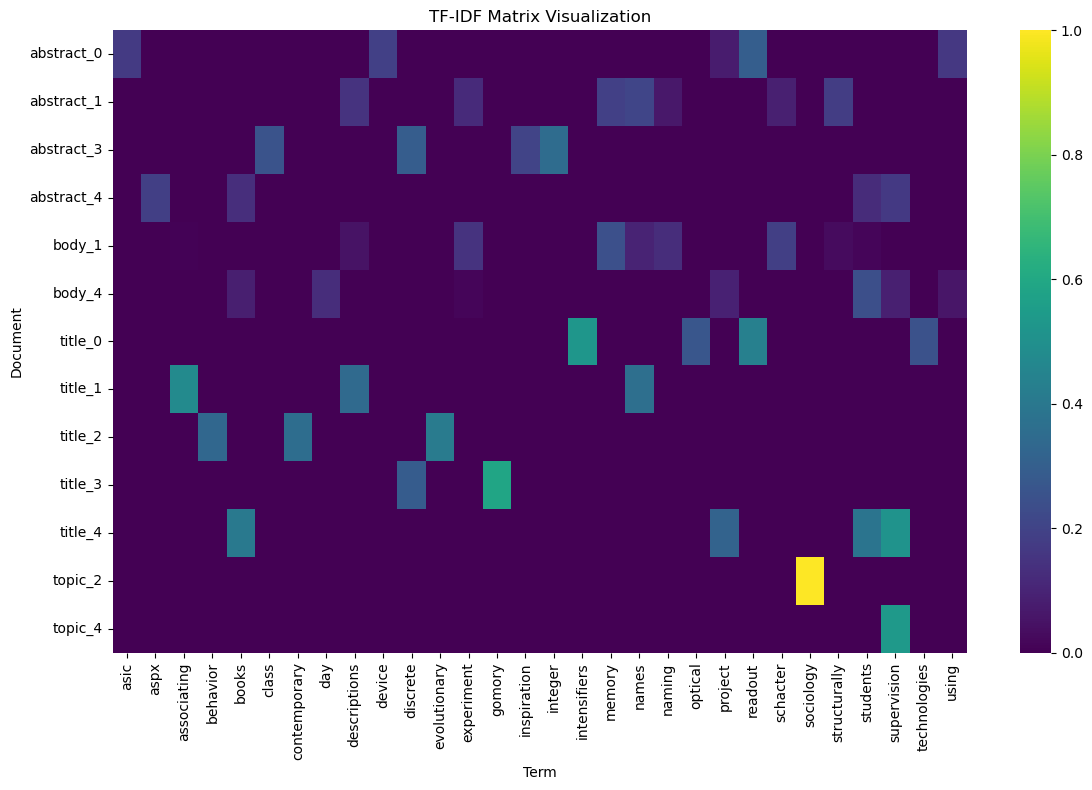


Sample of TF-IDF values:
  Document          Term    TF-IDF
0  title_0       optical  0.266316
1  title_0       readout  0.431452
2  title_0  technologies  0.253137
3  title_0  intensifiers  0.523507
4  title_1         names  0.362792
5  title_1  descriptions  0.343260
6  title_1   associating  0.475522
7  title_2  contemporary  0.353937
8  title_2  evolutionary  0.412079
9  title_2      behavior  0.329542


In [6]:
# Visualize the TF-IDF matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_tfidf_matrix(tfidf_data, num_docs=5, num_terms=10):
    """
    Create a visualization of the TF-IDF matrix for a sample of documents and terms.
    
    Args:
        tfidf_data: Dictionary with TF-IDF vectors and vectorizer
        num_docs: Number of documents to include in visualization
        num_terms: Number of top terms to include for each document
        
    Returns:
        DataFrame containing the TF-IDF values for visualization
    """
    # Get the feature names
    feature_names = tfidf_data['vectorizer'].get_feature_names_out()
    
    # Initialize a set to collect top terms across documents
    all_top_terms = set()
    
    # For each document type, find top terms
    for field in ['title', 'abstract', 'body', 'topic']:
        vectors = tfidf_data[f'{field}_vectors']
        
        # Skip if no documents
        if vectors.shape[0] == 0:
            continue
            
        # Look at first few documents
        for i in range(min(num_docs, vectors.shape[0])):
            if vectors[i].nnz == 0:  # Skip empty documents
                continue
                
            # Get top terms for this document
            indices = vectors[i].indices[np.argsort(vectors[i].data)[-num_terms:]]
            all_top_terms.update(feature_names[indices])
    
    # Convert to list and limit to a reasonable number
    top_terms = list(all_top_terms)[:30]  # Limit to 30 terms max
    
    # Create a DataFrame to hold the visualization data
    rows = []
    
    # For each field and document, extract TF-IDF values for top terms
    for field in ['title', 'abstract', 'body', 'topic']:
        vectors = tfidf_data[f'{field}_vectors']
        
        # Skip if no documents
        if vectors.shape[0] == 0:
            continue
            
        # Look at first few documents
        for i in range(min(num_docs, vectors.shape[0])):
            if vectors[i].nnz == 0:  # Skip empty documents
                continue
                
            # Get document vector as dense array
            doc_vector = vectors[i].toarray()[0]
            
            # For each top term, get its TF-IDF value in this document
            for term in top_terms:
                term_idx = np.where(feature_names == term)[0]
                if len(term_idx) > 0:
                    tfidf_value = doc_vector[term_idx[0]]
                    if tfidf_value > 0:  # Only include non-zero values
                        rows.append({
                            'Document': f"{field}_{i}",
                            'Term': term,
                            'TF-IDF': tfidf_value
                        })
    
    # Create DataFrame
    tfidf_df = pd.DataFrame(rows)
    
    # Create a pivot table for heatmap
    pivot_df = tfidf_df.pivot(index='Document', columns='Term', values='TF-IDF').fillna(0)
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, cmap='viridis', annot=False)
    plt.title('TF-IDF Matrix Visualization')
    plt.tight_layout()
    plt.show()
    
    return tfidf_df

# Visualize the TF-IDF matrix
tfidf_visualization = visualize_tfidf_matrix(tfidf_data)

# Display the raw data
print("\nSample of TF-IDF values:")
print(tfidf_visualization.head(10))


# apply field weight and combine the fields into a single vector 

In [7]:
import scipy 
def apply_field_weighting(tfidf_data, field_weights={'title': 3.0, 'abstract': 1.5, 'body': 1.0, 'topic': 2.0}):
    """
    Apply field weights to TF-IDF vectors and combine them with adaptive scaling
    
    Args:
        tfidf_data: Dictionary with TF-IDF vectors for each field
        field_weights: Dictionary mapping fields to weights
        
    Returns:
        Combined weighted document vectors
    """
    # Get shapes and create masks for empty documents
    title_mask = (tfidf_data['title_vectors'].getnnz(axis=1) > 0).astype(np.float64)
    abstract_mask = (tfidf_data['abstract_vectors'].getnnz(axis=1) > 0).astype(np.float64)
    body_mask = (tfidf_data['body_vectors'].getnnz(axis=1) > 0).astype(np.float64)
    topic_mask = (tfidf_data['topic_vectors'].getnnz(axis=1) > 0).astype(np.float64)
    
    # Calculate the combined weights for each document based on which fields exist
    total_weight = field_weights['title'] + field_weights['abstract'] + field_weights['body'] + field_weights['topic']
    
    # Create a multiplier for each document that accounts for missing fields
    title_weight = field_weights['title'] * title_mask
    abstract_weight = field_weights['abstract'] * abstract_mask
    body_weight = field_weights['body'] * body_mask
    topic_weight = field_weights['topic'] * topic_mask
    
    # Calculate scaling factor to normalize weights
    doc_weights = title_weight + abstract_weight + body_weight + topic_weight
    scaling_factors = np.divide(total_weight, doc_weights, out=np.zeros_like(doc_weights), where=doc_weights!=0)
    
    # Scale the weights by the scaling factors
    title_weight = np.multiply(title_weight, scaling_factors)
    abstract_weight = np.multiply(abstract_weight, scaling_factors)
    body_weight = np.multiply(body_weight, scaling_factors)
    topic_weight = np.multiply(topic_weight, scaling_factors)
    
    # Multiply each field by its weight and add them
    combined_vectors = (
        scipy.sparse.diags(title_weight).dot(tfidf_data['title_vectors']) +
        scipy.sparse.diags(abstract_weight).dot(tfidf_data['abstract_vectors']) +
        scipy.sparse.diags(body_weight).dot(tfidf_data['body_vectors']) +
        scipy.sparse.diags(topic_weight).dot(tfidf_data['topic_vectors'])
    )
    
    logging.info("Applied adaptive field weighting and combined vectors")
    return combined_vectors

# Apply field weighting
field_weights = {'title': 3.0, 'abstract': 1.5, 'body': 1.0, 'topic': 2.0}
combined_vectors = apply_field_weighting(tfidf_data, field_weights)

print(f"Combined vectors shape: {combined_vectors.shape}")
print("\nTop terms in combined weighted document:")
# Show top terms for the first document
show_top_terms(combined_vectors[0], tfidf_data['vectorizer'])



2025-03-25 13:09:46,812 - INFO - Applied adaptive field weighting and combined vectors


Combined vectors shape: (21840, 201492)

Top terms in combined weighted document:
device: 0.4761
design: 0.5287
multi: 0.7911
intensifier: 0.9047
technologies: 1.2657
optical: 1.3316
image: 1.4459
intensifiers: 2.6175
readout: 2.8968
demountable: 3.9371


# Visualise the Combined TF-IDF matirx 

In [8]:
# Create a DataFrame to visualize the TF-IDF matrix
def create_tfidf_matrix_df(vectors, vectorizer, n_docs=5, n_terms=10):
    """
    Create a DataFrame representation of the TF-IDF matrix
    
    Args:
        vectors: Document vectors from the TF-IDF matrix
        vectorizer: TfidfVectorizer used to create the vectors
        n_docs: Number of documents to include
        n_terms: Number of top terms to include per document
        
    Returns:
        DataFrame representation of the TF-IDF matrix
    """
    # Get feature names from vectorizer
    feature_names = vectorizer.get_feature_names_out()
    
    # Initialize the matrix DataFrame
    matrix_data = []
    
    # Process each document
    for doc_idx in range(min(n_docs, vectors.shape[0])):
        # Get the document vector
        doc_vector = vectors[doc_idx]
        if scipy.sparse.issparse(doc_vector):
            doc_vector = doc_vector.toarray().flatten()
        
        # Get indices of top terms for this document
        top_indices = doc_vector.argsort()[-n_terms:][::-1]
        
        # Add each term and its weight to the matrix
        for term_idx in top_indices:
            if doc_vector[term_idx] > 0:  # Only include non-zero weights
                matrix_data.append({
                    'Document': f'Doc {doc_idx}',
                    'Term': feature_names[term_idx],
                    'TF-IDF Weight': doc_vector[term_idx]
                })
    
    # Create DataFrame
    tfidf_matrix_df = pd.DataFrame(matrix_data)
    
    # Pivot the DataFrame to create a matrix view
    matrix_view = tfidf_matrix_df.pivot_table(
        index='Document', 
        columns='Term', 
        values='TF-IDF Weight',
        fill_value=0
    )
    
    return matrix_view

# Display the TF-IDF matrix for the first few documents
tfidf_matrix = create_tfidf_matrix_df(combined_vectors, tfidf_data['vectorizer'])
display(tfidf_matrix)




Term,associating,beej,behavior,bioscience,books,class,contemporary,demountable,descriptions,design,...,reproductive,shape,sociology,states,students,subadditive,supervision,technologies,united,wiki
Document,,,,,,,,,,,,,,,,,,,,,
Doc 0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,3.937082,0.000000,0.528664,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.265685,0.000000,0.000000
Doc 1,1.432319,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,1.298928,0.000000,...,0.000000,1.180507,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Doc 2,0.000000,0.000000,1.48294,0.000000,0.00000,0.000000,1.592716,0.000000,0.000000,0.000000,...,2.058833,0.000000,3.0,1.297735,0.000000,0.000000,0.000000,0.000000,1.268158,0.000000
Doc 3,0.000000,0.000000,0.00000,0.000000,0.00000,0.444346,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,2.494645,0.000000,0.000000,0.000000,0.000000
Doc 4,0.000000,0.912117,0.00000,0.663157,1.48792,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,1.576385,0.000000,2.959474,0.000000,0.000000,2.139791


# apply LSI using SVD 

2025-03-25 13:14:32,667 - INFO - Applied LSI with 150 dimensions
2025-03-25 13:14:32,668 - INFO - Explained variance: 22.64%


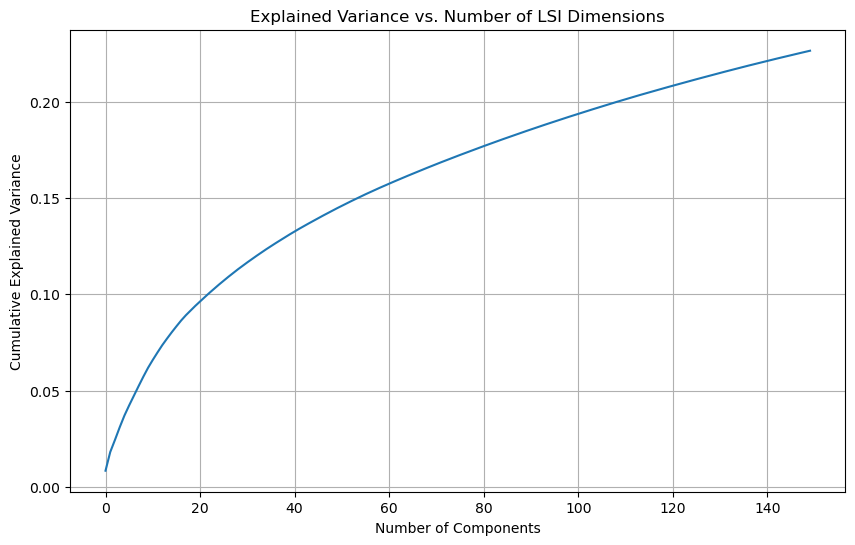

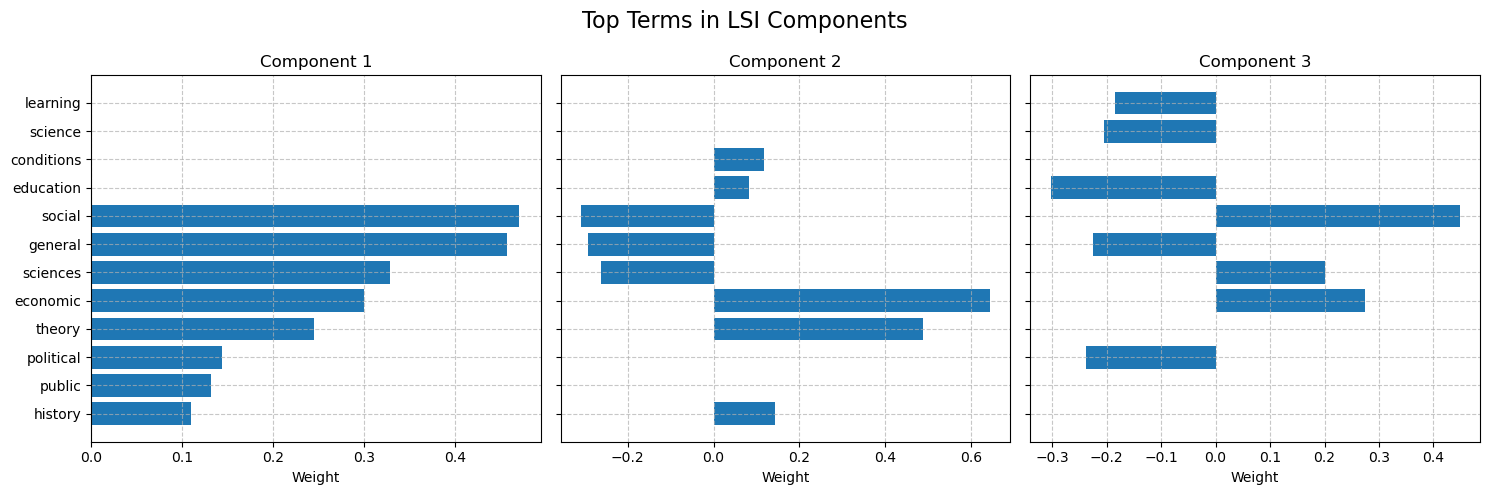

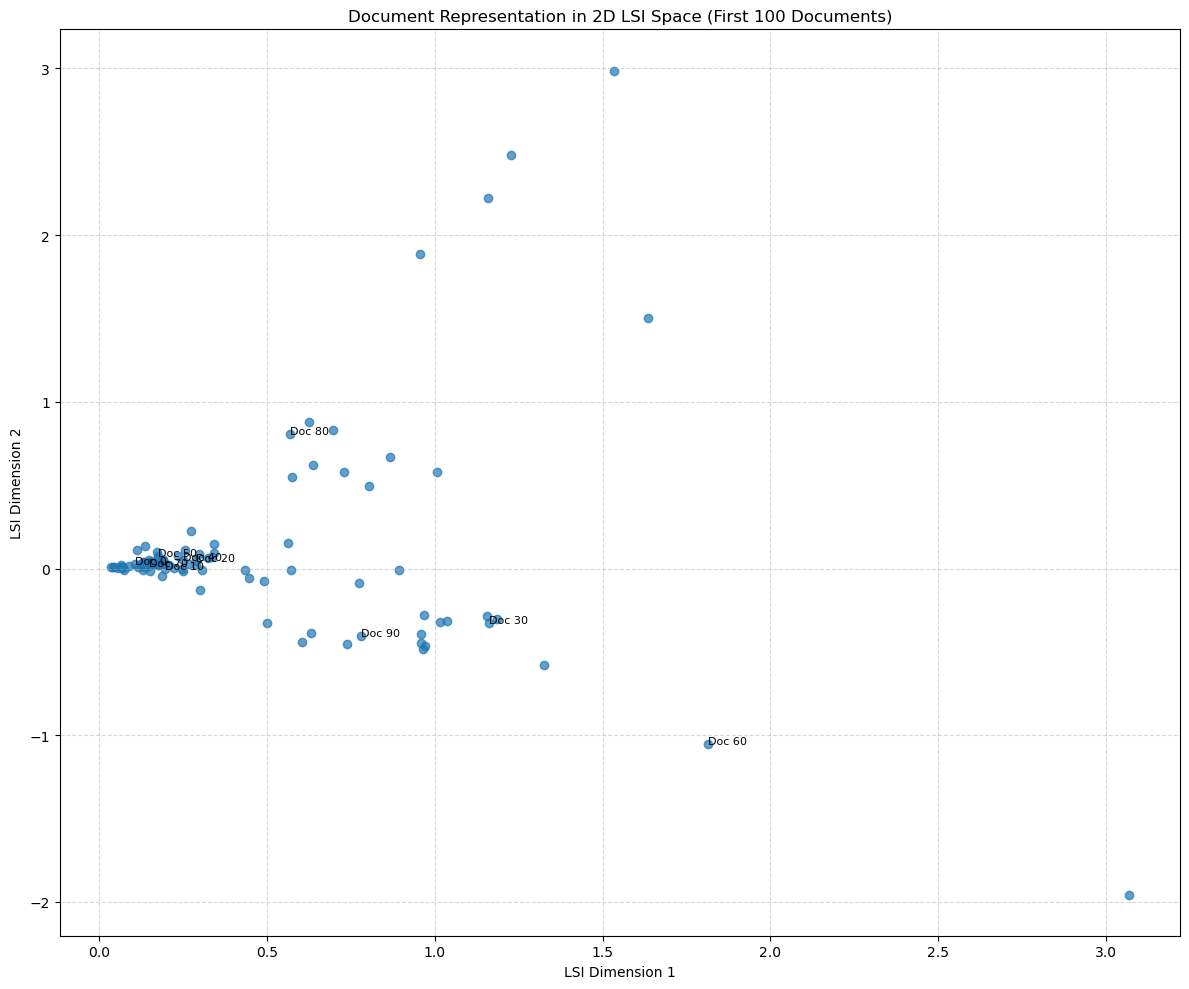

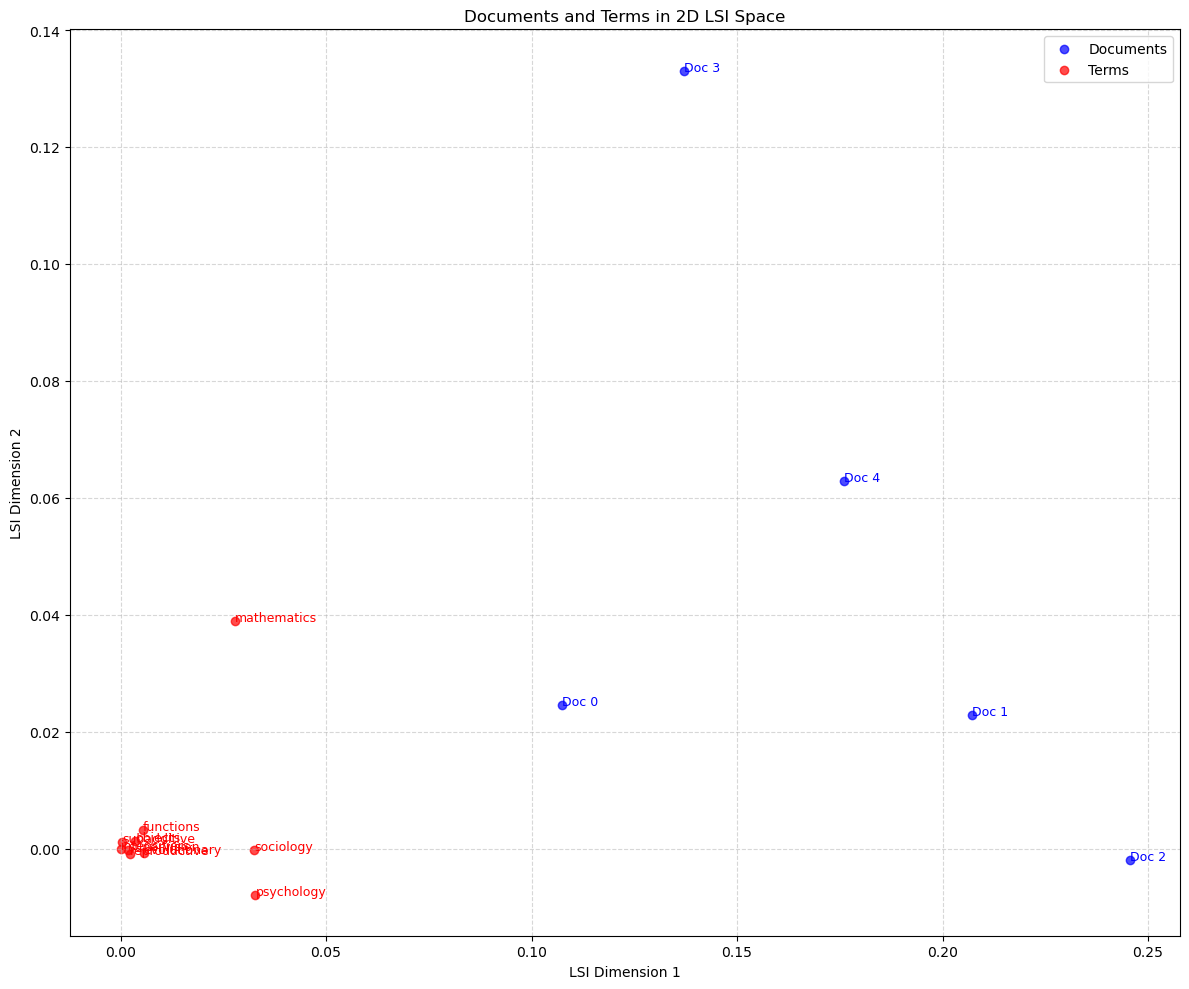

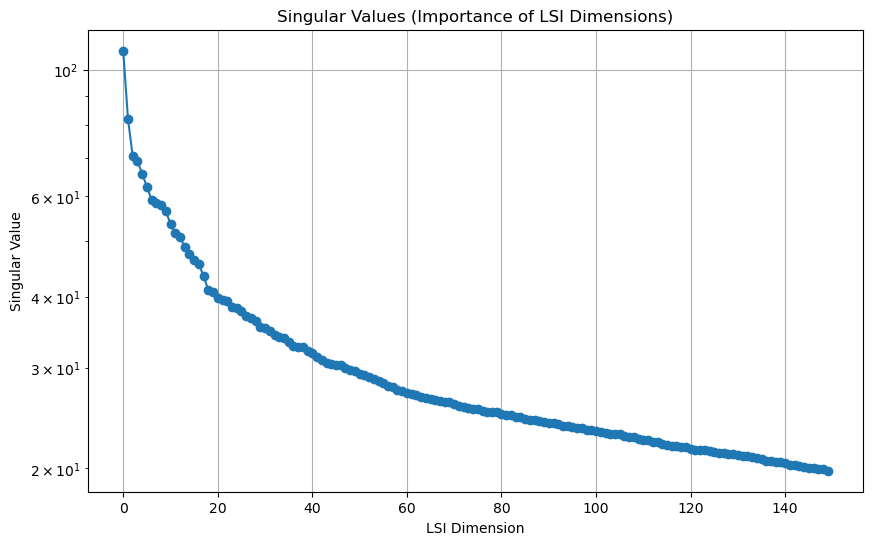

In [10]:
def apply_lsi(combined_vectors, n_dimensions=150):
    """
    Apply Latent Semantic Indexing using SVD
    
    Args:
        combined_vectors: Combined and weighted document vectors
        n_dimensions: Number of LSI dimensions to use
        
    Returns:
        Dictionary with SVD model and transformed vectors
    """
    # Create SVD model for dimensionality reduction
    svd_model = TruncatedSVD(n_components=n_dimensions, random_state=42)
    
    # Apply SVD to create LSI representation
    lsi_vectors = svd_model.fit_transform(combined_vectors)
    
    # Normalize the vectors for cosine similarity
    normalized_lsi_vectors = normalize(lsi_vectors)
    
    logging.info(f"Applied LSI with {n_dimensions} dimensions")
    logging.info(f"Explained variance: {svd_model.explained_variance_ratio_.sum():.2%}")
    
    return {
        'svd_model': svd_model,
        'lsi_vectors': lsi_vectors,
        'normalized_lsi_vectors': normalized_lsi_vectors
    }

# Apply LSI
lsi_data = apply_lsi(combined_vectors, n_dimensions=150)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(lsi_data['svd_model'].explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of LSI Dimensions')
plt.grid(True)
plt.show()

# Visualize the components and their relationship to terms
def visualize_lsi_components(svd_model, feature_names, n_top_terms=10, n_components=5):
    """
    Visualize the top terms associated with each LSI component
    
    Args:
        svd_model: Trained SVD model
        feature_names: List of feature names (terms)
        n_top_terms: Number of top terms to display per component
        n_components: Number of components to visualize
    """
    # Get the components (term-topic matrix)
    components = svd_model.components_
    
    # Create a figure with subplots for each component
    fig, axes = plt.subplots(1, min(n_components, components.shape[0]), 
                             figsize=(15, 5), sharey=True)
    
    # If only one component is shown, axes is not an array
    if n_components == 1:
        axes = [axes]
    
    # For each component
    for i, ax in enumerate(axes):
        if i >= components.shape[0]:
            break
            
        # Get the top terms for this component
        top_term_indices = np.abs(components[i]).argsort()[-n_top_terms:]
        top_terms = [feature_names[idx] for idx in top_term_indices]
        top_weights = components[i][top_term_indices]
        
        # Sort by weight for better visualization
        sorted_indices = np.argsort(top_weights)
        top_terms = [top_terms[j] for j in sorted_indices]
        top_weights = top_weights[sorted_indices]
        
        # Create horizontal bar chart
        ax.barh(top_terms, top_weights)
        ax.set_title(f'Component {i+1}')
        ax.set_xlabel('Weight')
        
        # Add gridlines
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.suptitle('Top Terms in LSI Components', fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()

# Get feature names from the vectorizer
feature_names = tfidf_data['vectorizer'].get_feature_names_out()

# Visualize top terms in the first few LSI components
visualize_lsi_components(lsi_data['svd_model'], feature_names, n_top_terms=8, n_components=3)

# Visualize document clusters in 2D LSI space
plt.figure(figsize=(12, 10))
# Use only first two dimensions for visualization
x = lsi_data['lsi_vectors'][:100, 0]  # First 100 documents, first dimension
y = lsi_data['lsi_vectors'][:100, 1]  # First 100 documents, second dimension

# Create scatter plot
scatter = plt.scatter(x, y, alpha=0.7)
plt.title('Document Representation in 2D LSI Space (First 100 Documents)')
plt.xlabel('LSI Dimension 1')
plt.ylabel('LSI Dimension 2')
plt.grid(True, linestyle='--', alpha=0.5)

# Add document indices for reference
for i, (x_val, y_val) in enumerate(zip(x, y)):
    if i % 10 == 0:  # Label every 10th document to avoid clutter
        plt.annotate(f'Doc {i}', (x_val, y_val), fontsize=8)

plt.tight_layout()
plt.show()

# Visualize term-document relationships in LSI space
def plot_term_document_lsi_space(lsi_vectors, svd_model, feature_names, doc_indices, term_indices):
    """
    Plot documents and terms in the same LSI space
    
    Args:
        lsi_vectors: Document vectors in LSI space
        svd_model: Trained SVD model
        feature_names: List of feature names
        doc_indices: Indices of documents to plot
        term_indices: Indices of terms to plot
    """
    # Get the term vectors in LSI space (using the right singular vectors)
    term_vectors = svd_model.components_.T
    
    plt.figure(figsize=(12, 10))
    
    # Plot documents
    doc_x = lsi_vectors[doc_indices, 0]
    doc_y = lsi_vectors[doc_indices, 1]
    plt.scatter(doc_x, doc_y, color='blue', alpha=0.7, label='Documents')
    
    # Plot terms
    term_x = term_vectors[term_indices, 0]
    term_y = term_vectors[term_indices, 1]
    plt.scatter(term_x, term_y, color='red', alpha=0.7, label='Terms')
    
    # Add labels
    for i, idx in enumerate(doc_indices):
        plt.annotate(f'Doc {idx}', (doc_x[i], doc_y[i]), fontsize=9, color='blue')
    
    for i, idx in enumerate(term_indices):
        plt.annotate(feature_names[idx], (term_x[i], term_y[i]), fontsize=9, color='red')
    
    plt.title('Documents and Terms in 2D LSI Space')
    plt.xlabel('LSI Dimension 1')
    plt.ylabel('LSI Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Find some interesting terms to visualize
# Get the most important terms from the first few documents
important_terms = []
for doc_idx in range(5):
    doc_vector = combined_vectors[doc_idx]
    if scipy.sparse.issparse(doc_vector):
        doc_vector = doc_vector.toarray().flatten()
    
    # Get indices of top terms for this document
    top_indices = doc_vector.argsort()[-3:][::-1]  # Top 3 terms per document
    important_terms.extend(top_indices)

# Remove duplicates
important_terms = list(set(important_terms))

# Plot documents and terms in LSI space
plot_term_document_lsi_space(
    lsi_data['lsi_vectors'], 
    lsi_data['svd_model'], 
    feature_names, 
    doc_indices=list(range(5)),  # First 5 documents
    term_indices=important_terms[:10]  # First 10 important terms
)

# Visualize the singular values (importance of each dimension)
plt.figure(figsize=(10, 6))
plt.plot(lsi_data['svd_model'].singular_values_, 'o-')
plt.title('Singular Values (Importance of LSI Dimensions)')
plt.xlabel('LSI Dimension')
plt.ylabel('Singular Value')
plt.grid(True)
plt.yscale('log')  # Log scale often helps visualize the decay pattern
plt.show()